In [19]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
df = pd.read_csv("filtered_data.csv")

In [35]:
new_time = np.arange(0, len(df['Testtime [s]']))
df['Testtime [s]'] = new_time
drive_cycle = df.to_numpy()
time_data = drive_cycle[:, 1]  # Time data in seconds
current_data = drive_cycle[:, 3]  # Current data in amperes

In [36]:
time_data.shape[0]

63519

In [51]:
# Step 1：Creating Interpolation Functions
# Creating interpolant functions with pybamm.Interpolant
current_interpolant = pybamm.Interpolant(time_data, current_data, pybamm.t)

# Step 2：Using Interpolation Functions in Models
# Create a simple DFN model
model = pybamm.lithium_ion.DFN()

# Setting the current function）
param = pybamm.ParameterValues("OKane2022")
param["Current function [A]"] = current_interpolant

# Creating Simulation Objects
solver = pybamm.CasadiSolver(mode="fast")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver)

# Running simulations with time ranges consistent with data
solution = simulation.solve()  
# simulation.plot()

# Getting results
time = solution["Time [s]"].entries
current = solution["Current [A]"].entries
voltage = solution["Terminal voltage [V]"].entries


In [52]:
#
voltage_ex = df["Voltage[V]"].to_numpy()
time_ex = df["Testtime [s]"].to_numpy()

KeyError: 'Voltage[V]'

In [53]:
df.shape[0]

63519

In [54]:
df_sim = pd.DataFrame()
df_sim["Testtime [s]"] = time
df_sim["Voltage[V]"] = voltage
df_sim.to_csv("data/data_ocv_sim.csv", index=False)

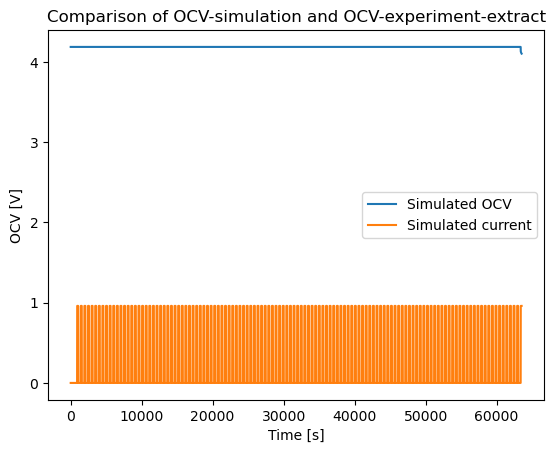

In [55]:
plt.plot(time_ex, voltage_ex, label='experimental OCV')
plt.plot(time, voltage, label='Simulated OCV')
plt.xlabel('Time [s]')
plt.ylabel('OCV [V]')
plt.title('Comparison of OCV-simulation and OCV-experiment-extract')
plt.legend()
plt.show()


In [50]:
# Reading CSV files
df1 = pd.read_csv('data/data_ocv_ex.csv')
df2 = pd.read_csv('data/data_ocv_sim.csv')

# Extract the columns to be compared
ex = df1['Testtime [s]']
sim = df2['Testtime [s]']

# Compare two columns of data to see if they are identical
if ex.equals(sim):
    print('The columns are exactly the same.')
else:
    print('The columns are different.')


The columns are different.


In [15]:
ex.shape[0]


63519

In [16]:
sim.shape[0]

63386